# Electricity Price Forecasting with Deep Neural Networks

In [1]:
# import important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import data
df_w = pd.read_csv('./data/weather_features.csv')
df_w.head(3)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [3]:
# import data
df_e = pd.read_csv('./data/energy_dataset.csv')
df_e.head(3)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48


We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable. We will also remove the columns which will not be used at all in our analysis and which contain day-ahead forecasts for the total load, the solar energy and the wind energy.

In [4]:
# Drop unusable columns
df_e = df_e.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [5]:
df_e.head(3)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48


In [7]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
time                                           35064 non-null object
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non-null float64
generation hydro water reservoir               35046 non-null float64
generation nuclear                             35047 non-null float64
generation other                               35046 non-null float64
generation other renewable                     35046 non-null float64
generation solar                               35046

In [12]:
print('There are {} missing values or NaNs in df_energy.'.format(df_e.isnull().values.sum()))

temp_energy = df_e.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'.format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [10]:
df_e.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.000000,35046.000000,35045.000000,35045.000000,35045.000000,35046.000000,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,28696.939905,49.874341,57.884023
std,85.353943,354.568590,2201.830478,1961.601013,52.520673,792.406614,400.777536,1835.199745,839.667958,20.238381,14.077554,1680.119887,50.195536,3213.691587,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1077.250000,5760.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,4969.000000,4474.000000,300.000000,68.000000,906.000000,2164.000000,6566.000000,57.000000,88.000000,616.000000,279.000000,4849.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,6429.000000,5838.750000,330.000000,616.000000,1250.000000,3757.000000,7025.000000,80.000000,97.000000,2578.000000,310.000000,7398.000000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,41015.000000,101.990000,116.800000


In [11]:
# Convert time to datetime
df_e['time'] = pd.to_datetime(df_e['time'], utc=True, infer_datetime_format=True)
df_e = df_e.set_index('time')

In [13]:
def plot_s(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

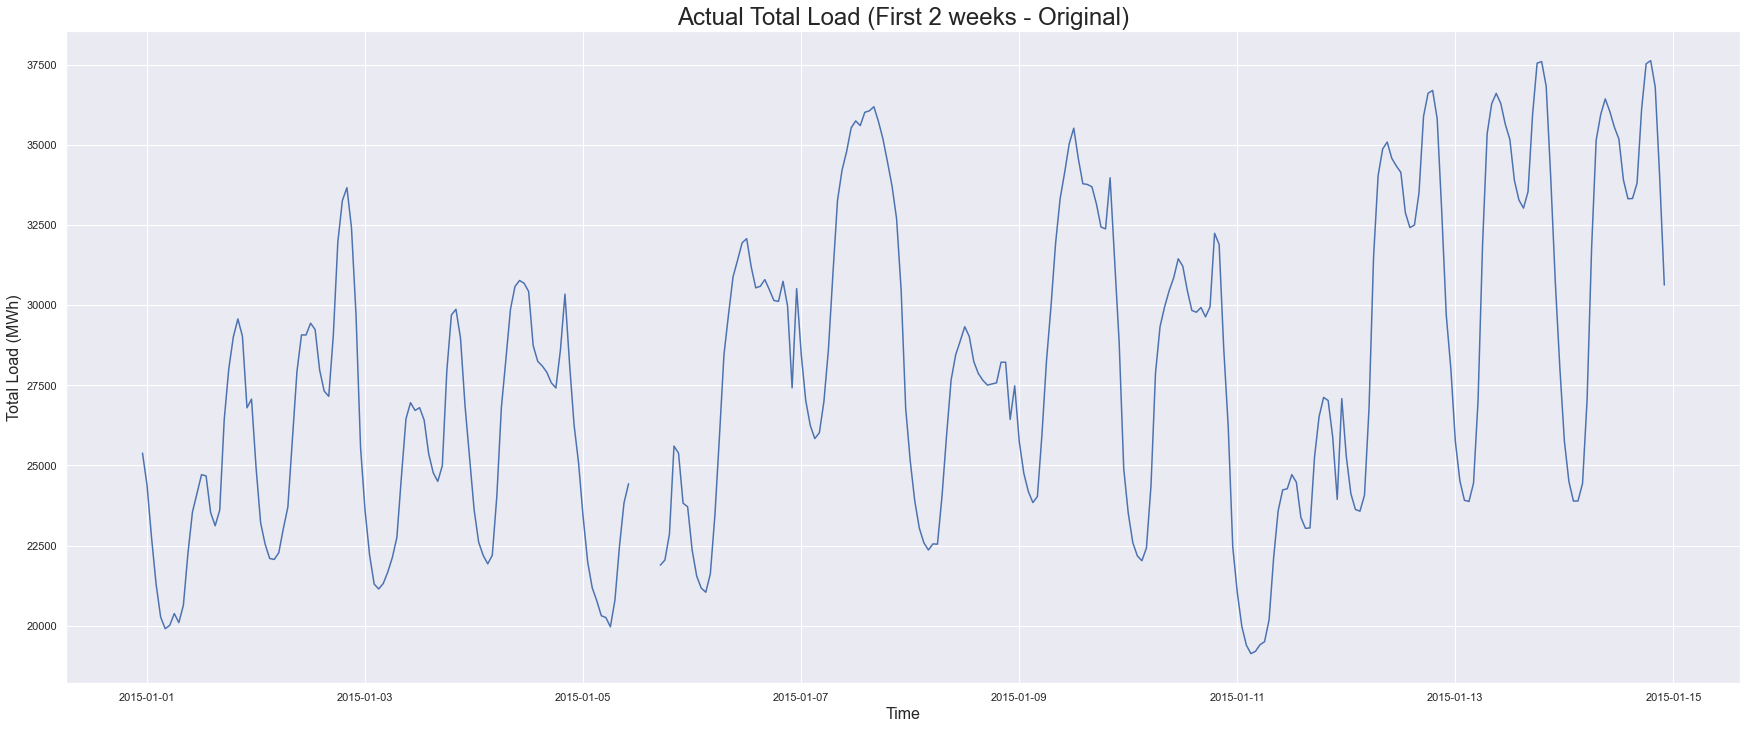

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
ax = plot_s(df=df_e, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()